In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,Activation,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
labels=['PNEUMONIA','NORMAL']
img_size=224
def get_training_data(data_dir):
    data=[]
    for label in labels:
        path = os.path.join(data_dir,label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                resized_arr= cv2.resize(img_arr,(img_size,img_size))
                data.append([resized_arr,class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:


from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train = get_training_data('/content/drive/MyDrive/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


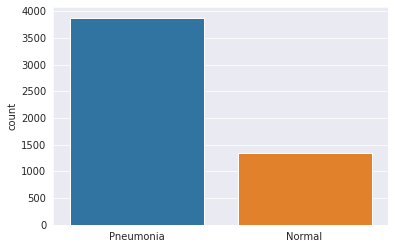

In [ ]:
l =[]
for i in train:
    if(i[1] == 0):
       l.append("Pneumonia")
    else:
       l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)


Text(0.5, 1.0, 'NORMAL')

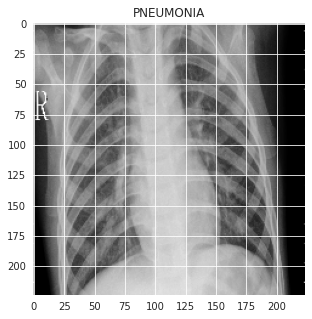

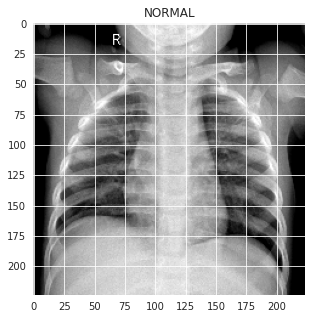

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []
for feature,label in train:
  x_train.append(feature)
  y_train.append(label)
for feature,label in test:
  x_test.append(feature)
  y_test.append(label)
for feature,label in val:
  x_val.append(feature)
  y_val.append(label)


In [ ]:
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [ ]:
x_train = x_train.reshape(-1,img_size,img_size,1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1,img_size,img_size,1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1,img_size,img_size,1)
y_test = np.array(y_test)

In [ ]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range = 30,
                            zoom_range = 0.2,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)
datagen.fit(x_train)

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3,3) , strides = 1 , padding = 'same', activation = 'relu',input_shape = (224,224,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3) , strides = 1 , padding = 'same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3) , strides = 1 , padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3) , strides = 1 , padding = 'same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2, padding = 'same'))
model.add(Conv2D(256, (3,3) , strides = 1 , padding = 'same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience = 2,verbose = 1, factor=0.3, min_lr = 0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train,batch_size = 32),epochs = 10,validation_data = datagen.flow(x_val,y_val),callbacks = [learning_rate_reduction])

Epoch 1/10
164/164 [==============================] - 1057s 6s/step - loss: 0.6268 - accuracy: 0.8446 - val_loss: 77.6181 - val_accuracy: 0.5000
Epoch 2/10
164/164 [==============================] - 1068s 7s/step - loss: 0.2675 - accuracy: 0.8990 - val_loss: 69.0190 - val_accuracy: 0.5000
Epoch 3/10
164/164 [==============================] - 1069s 7s/step - loss: 0.2398 - accuracy: 0.9138 - val_loss: 38.8682 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
164/164 [==============================] - 1072s 7s/step - loss: 0.1634 - accuracy: 0.9456 - val_loss: 30.1245 - val_accuracy: 0.5000
Epoch 5/10
164/164 [==============================] - 1077s 7s/step - loss: 0.1427 - accuracy: 0.9548 - val_loss: 2.8802 - val_accuracy: 0.7500
Epoch 6/10
164/164 [==============================] - 1068s 7s/step - loss: 0.1419 - accuracy: 0.9536 - val_loss: 47.9798 - val_accuracy: 0.5000
Epoch 7/10
164/164 [==============================

In [ ]:
print("LOSS OF THE MODEL IS = ",model.evaluate(x_test,y_test)[0])
print("ACCURACY OF THE MODEL IS = ",model.evaluate(x_test,y_test)[1]*100,"%")

20/20 [==============================] - 26s 1s/step - loss: 0.4141 - accuracy: 0.8926
LOSS OF THE MODEL IS =  0.41410523653030396
20/20 [==============================] - 25s 1s/step - loss: 0.4141 - accuracy: 0.8926
ACCURACY OF THE MODEL IS =  89.26281929016113 %


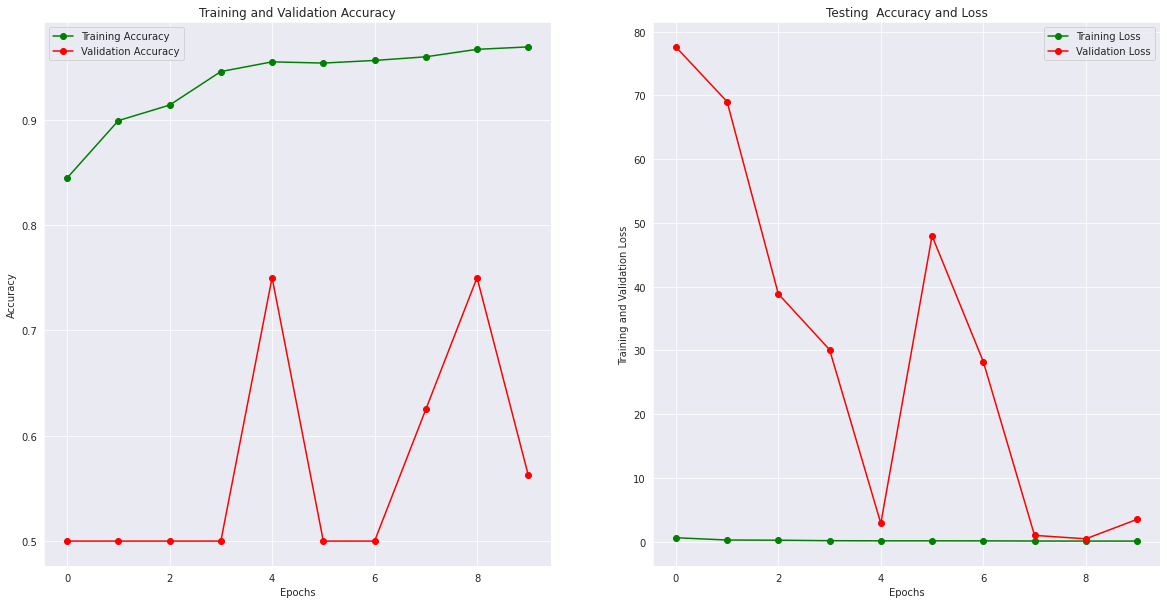

In [ ]:
epochs = [i for i in range(10)]
fig,ax = plt.subplots(1,2)
train_acc=history.history['accuracy']
train_loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs,train_acc,'go-',label = 'Training Accuracy')
ax[0].plot(epochs,val_acc,'ro-',label = 'Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs,train_loss,'g-o',label = 'Training Loss')
ax[1].plot(epochs,val_loss,'r-o',label = 'Validation Loss')
ax[1].set_title('Testing  Accuracy and Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training and Validation Loss")
plt.show()

In [ ]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test,predictions,target_names=['Pneumonia(Class 0)','Normal(Class 1)']))

                    precision    recall  f1-score   support

Pneumonia(Class 0)       0.89      0.94      0.92       390
   Normal(Class 1)       0.89      0.82      0.85       234

          accuracy                           0.89       624
         macro avg       0.89      0.88      0.88       624
      weighted avg       0.89      0.89      0.89       624



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[366,  24],
       [ 43, 191]])

In [ ]:
cm=pd.DataFrame(cm, index = ['0','1'],columns = ['0','1'])

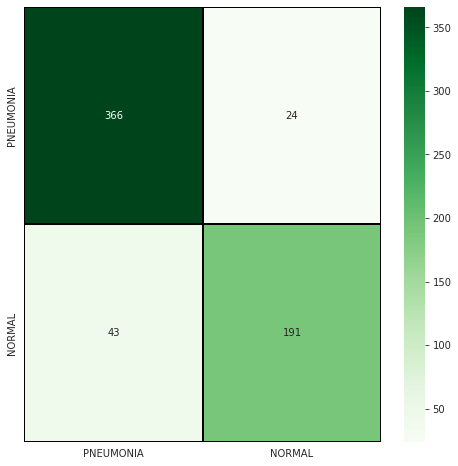

In [ ]:
plt.figure(figsize = (8,8))
sns.heatmap(cm,cmap = "Greens",linecolor = 'black', linewidth = 1, annot = True, fmt='', xticklabels = labels, yticklabels = labels)

In [ ]:
Sensitivity = 375/(375+41)
print(Sensitivity)

0.9014423076923077


In [ ]:
Specificity = 193/(193+15)
print(Specificity)

0.9278846153846154


In [ ]:
dice_factor = (2*375)/((2*375)+15+45)
print(dice_factor)

0.9259259259259259


In [ ]:
correct=np.nonzero(predictions == y_test)[0]
incorrect=np.nonzero(predictions != y_test)[0]

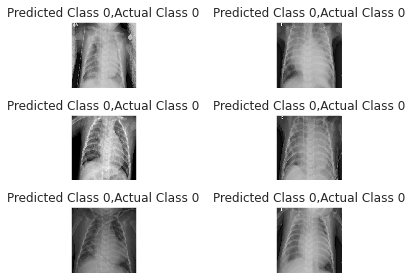

In [ ]:
#CORRECTLY PREDICTED CLASSES
i = 0
for c in correct[:6]:
  plt.subplot(3,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224),cmap = "gray", interpolation = 'none')
  plt.title("Predicted Class {},Actual Class {}".format(predictions[c],y_test[c]))
  plt.tight_layout()
  i += 1

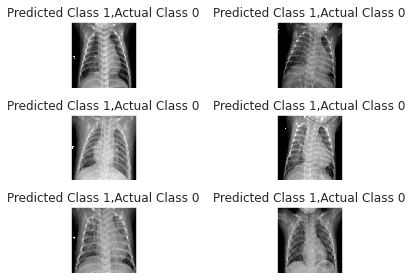

In [ ]:
#INCORRECTLY PREDICTED CLASSES
i = 0
for c in incorrect[:6]:
  plt.subplot(3,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224),cmap = "gray", interpolation = 'none')
  plt.title("Predicted Class {},Actual Class {}".format(predictions[c],y_test[c]))
  plt.tight_layout()
  i += 1